# About The Dataset Origin
The Missouri Botanical Garden (MOBOT) hosts a convinent and comprehensive database called "Plant Finder": https://www.missouribotanicalgarden.org/plantfinder/plantfindersearch.aspx
# About Retrieving the Dataset
See the python script get_da_mobot.py
# About Cleaning the Dataset
See the python script transform_da_mobot.py
# What we're going to do here
1. Find broad trends in the dataset to understand the information is has to give
2. Build queries and visualizations that are human brain-friendly to gather insights into some fun questions like "What can I plant for a flower garden in zone 6 that is all red?"

## Install and import libraries from the start

In [32]:
import sys

import requests

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install chart_studio 
!{sys.executable} -m pip install matplotlib

import numpy as np
import pandas as pd
import chart_studio as py
from matplotlib import pyplot as plt

## Bring in the csv file we created from scrapping and cleaning the HTML from MOBOT's site and let's take a look

In [33]:
df = pd.read_csv("./plants_mobot.csv")

### We need to make a point of being sure every single row as a unique identifier so the following uses the family name, the formal name, and the common name to do it

In [34]:
df = df.assign(id=(df['Family'].str.lower().replace(' ', '_') +df['Formal Name'].str.lower().replace(' ', '_') + '_' + df['Common Name'].str.lower().replace(' ', '_')).astype('category').cat.codes)

### Let's check the number of rows. If we managed to get a truely unique id for each instance, there should be  same number of ids as rows

In [35]:
index = df. index
number_of_rows = len(index) #find length of index.
number_of_rows

8145

#### 7952 is our number of rows and below we see the same number for the unique count of ids. We have a unique column in addition to the index.

In [36]:
df['id'].nunique()

8145

#### We are also dealing with some issues that will be problems in the upcoming data transformations. Code needs data types to be exact. Python, unlike something like Java, handles data types automatically more or less. But that isn't useful if a dataframe as a data type as an "object" and we need to do something like use a string based boolean query.

In [37]:
df.dtypes

Attracts                       object
Bloom Description              object
Bloom Time                     object
Common Name                    object
Culture                       float64
Family                         object
Flower                         object
Formal Name                    object
Fruit                          object
Garden Uses                   float64
Height                         object
Invasive                       object
Leaf                           object
Maintenance                    object
Native Range                   object
Noteworthy Characteristics    float64
Other                          object
Problems                      float64
Spread                         object
Suggested Use                  object
Sun                            object
Tolerate                       object
Type                           object
Water                          object
Zone                           object
id                              int16
dtype: objec

In [38]:
df['Attracts'] = df['Attracts'].astype(str)
df['Bloom_Description'] = df['Bloom Description'].astype(str)
df['Bloom_Time'] = df['Bloom Time'].astype(str)
df['Common_Name'] = df['Common Name'].astype(str)
df['Culture'] = df['Culture'].astype(str)
df['Family'] = df['Family'].astype(str)
df['Flower'] = df['Flower'].astype(str)
df['Formal_Name'] = df['Formal Name'].astype(str)
df['Fruit'] = df['Fruit'].astype(str)
df['Garden_Uses'] = df['Garden Uses'].astype(str)
df['Height'] = df['Height'].astype(str)
df['Invasive'] = df['Invasive'].astype(str)
df['Leaf'] = df['Leaf'].astype(str)
df['Maintenance'] = df['Maintenance'].astype(str)
df['Native_Range'] = df['Native Range'].astype(str)
df['Noteworthy_Characteristics'] = df['Noteworthy Characteristics'].astype(str)
df['Other'] = df['Other'].astype(str)
df['Problems'] = df['Problems'].astype(str)
df['Spread'] = df['Spread'].astype(str)
df['Suggested_Use'] = df['Suggested Use'].astype(str)
df['Sun'] = df['Sun'].astype(str)
df['Tolerate'] = df['Tolerate'].astype(str)
df['Type'] = df['Type'].astype(str)
df['Water'] = df['Water'].astype(str)
df['Zone'] = df['Zone'].astype(str)

We also see in the dataset several messy columns for the purposes of exploring the dataset.

Code is based on hard rules. Human language is not. We for examplehave strings like "Deer" and "Drought" in the column called "Tolerate" . We also have strings like "Clay Soil" and "Wet Soil". So we cannot separate these strings by just saying we need to split this by space. There are more rules to create. Ultimately, I took this entire column, and narrowed the possible strings down to just 11 possibilities. They are 'Air Pollution', 'Black Walnut', 'Clay Soil', 'Dry Soil', 'Wet Soil', 'Deer', 'ShallowRocky Soil', 'Drought', 'Erosion', 'Heavy Shade', and 'Rabbit'. Even if we were to go to the Plant Finder page and essentially see these exact same words, they are completely the same and in order for the code to understand what we what, what we ask and what it has needs to be exactly the same.

Another "problem" column is Zone. The human brain can read an entry in that column that may say "6 to 9" and automatically we are processing "Ah, so this applies to zones 6, 7, 8, and 9". However, Python doesn't automatically do that. If we were to try to find the number of plants and group them by zones, we wouldn't get neat rows of single numbers, but whatever ranges has been entered into the data.

For the "Tolerate" column, this will take literally just looking at the data. I sometimes like to take a look at it in a text editor. Sometimes even Excel just to get grounded because the data is spaced out and easier to read.

For the "Zone" column, this can be looked at in a more automated way.

In [39]:
#The following takes the Zone column and makes it into a delimited list of zones from the range provided

#Set up a list for the new zone column. Data maintainance rules typically do not encourage destroying 
#columns that need to be cleaned. They rather encourage new columns to be created along the same index with the new
#data.
full_list_of_zones = []

for row in df['Zone']:
    #looping through each instance in the column, we want to take out the leading white space and the ' to ' string
    #in the middle of the data entry
    zone_range_list = row.lstrip(' ').split(' to ')
    #in order to count, this list needs to be set as numbers. They are still strings
    zone_range_list = [ int(x) for x in zone_range_list ]
    #using range in Python, we can pull together a full list of the numbers possible in just one line
    full_zone_range_list = [*range(zone_range_list[0],zone_range_list[-1]+1,1)]
    #now we add that new list to the empty list we had created
    full_list_of_zones.append(full_zone_range_list)


#We now have a list of values that are in the exact order and perfect size for the dataframe.
#We can now just declare the list to be a new column, which is automatically placed at the end
#We will also make it a string for now anyway for the purposes of using it for querying later with the other columns
df['Zone_List'] = full_list_of_zones


### Checking the work just in case

In [40]:
df.sample(5)

,Attracts,Bloom Description,Bloom Time,Common Name,Culture,Family,Flower,Formal Name,Fruit,Garden Uses,...,id,Bloom_Description,Bloom_Time,Common_Name,Formal_Name,Garden_Uses,Native_Range,Noteworthy_Characteristics,Suggested_Use,Zone_List
4691,Butterflies,Pale pink to dark purple,July to September,coastal plain joe pye weed,nan,Asteraceae,Showy Fragrant,Eutrochium dubium,Showy,NaN,...,1621,Pale pink to dark purple,July to September,coastal plain joe pye weed,Eutrochium dubium,nan,Eastern North America,nan,Rain Garden,"[3, 4, 5, 6, 7, 8, 9]"
1070,Birds Hummingbirds Butterflies,Pale yellow,February to March,Japanese witch hazel,nan,Hamamelidaceae,Showy,Hamamelis japonica var obtusata,Showy,NaN,...,4115,Pale yellow,February to March,Japanese witch hazel,Hamamelis japonica var obtusata,nan,Japan,nan,Hedge,"[5, 6, 7, 8]"
1138,Birds,Most colors except green,Seasonal bloomer,polyanthus,nan,Primulaceae,Showy,Primula polyanthus type,Showy,NaN,...,6495,Most colors except green,Seasonal bloomer,polyanthus,Primula polyanthus type,nan,Southern China Taiwan,nan,Annual Ground Cover,"[5, 6, 7]"
4995,Hummingbirds,Yellow tinged with purple,May to June,sweet spurge,nan,Euphorbiaceae,Showy,Euphorbia dulcis,Showy,NaN,...,3653,Yellow tinged with purple,May to June,sweet spurge,Euphorbia dulcis,nan,Europe,nan,Annual,"[5, 6, 7, 8]"
7294,Butterflies,Indigo blue,May to June,blue false indigo,nan,Fabaceae,Showy,Baptisia australis,Showy,NaN,...,3696,Indigo blue,May to June,blue false indigo,Baptisia australis,nan,Eastern United States,nan,Naturalize,"[3, 4, 5, 6, 7, 8, 9]"


## Let's take a look at the broad trends in the data to get a grip about the information

---
**NOTE**
The most basic thing we can do in Pandas is use the summarization tools the library provides. In some cases, the number of options for something like an x axis of a bar chart are simply too many, so we can cut it down by only looking at cases. The top 10 for the columns we will be exploring. For Pandas, we can do that with "nlargest". Other methods could work though like finding the median or mean and using that to filter "top" values.

---

## Let's start with the plant families we have to work with. What are the most abuntent families in terms of information MOBOT has?

In [41]:
family_distribution = pd.DataFrame({'count' : df.groupby( ["Family"] ).size()}).sort_values('count', ascending=False).reset_index()

In [42]:
family_distribution = family_distribution.sort_values(['count'], ascending=False).head(5)

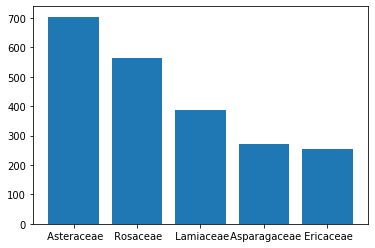

In [43]:
x = family_distribution['Family'] 
y = family_distribution['count']

plt.bar(x, y)

plt.show()

## MOBOT has the most plants in its Plant Finder hailing from the Asteraceae Family, also known as the "Daisy Family". This is followed by the Rosaceae Family, the "Rose Family". Given MOBOT has a part of the garden dedicated soley to roses, this isn't surprising for that alone!

## Let's look at suggested uses next. What are these plants in the Plant Finder most likely going to be used for?

In [44]:
suggested_use_distribution = pd.DataFrame({'count' : df.groupby( ['Suggested Use'] ).size()}).sort_values('count', ascending=False).reset_index()

In [45]:
suggested_use_distribution = suggested_use_distribution.sort_values(['count'], ascending=False).head(10)

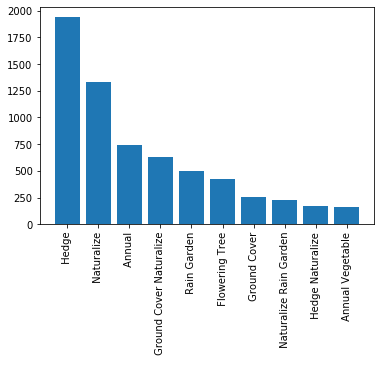

In [58]:
x = suggested_use_distribution['Suggested Use'] 
y = suggested_use_distribution['count']

plt.bar(x, y)

plt.xticks(rotation=90)

plt.show()


## Hedges are the most common! How....common? However, we can see there's also quite a few options for rain gardens. And over 500 annuals!

## MOBOT has experts in plants from all over the world. Where are most of those plants they have knowledge of from in the Plant finder?

In [53]:
native_range_distribution = pd.DataFrame({'count' : df.groupby( ['Native Range'] ).size()}).sort_values('count', ascending=False).reset_index()


In [54]:
native_range_distribution = native_range_distribution.sort_values(['count'], ascending=False).head(10)

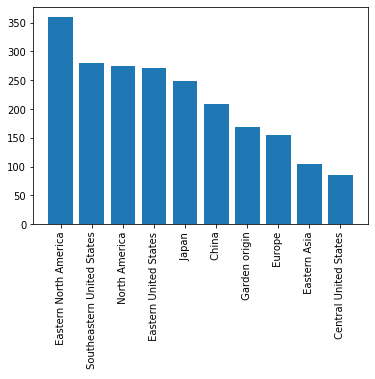

In [57]:
x = native_range_distribution['Native Range']
y = native_range_distribution['count']

plt.bar(x, y)

plt.xticks(rotation=90)

plt.show()


## Unsurprisingly, an American botanical garden in Missouri has most plants from the Americas. Japanese and Chinese plants holding the fifth and sixth spots respectively is interesting, but unsprizing! Large chunks of MOBOT's garden is dedicated to these countries.

## The United States Department of Agriculture (USDA) classifies different parts of the United States in plant hardiness zones that note the particular climate is in that part of the United States and help gardeners and farmers figure out what they can grow and where. 


---
**NOTE**
You can find out your zone with your zip code here at the USDA's website for plant hardiness zones: https://planthardiness.ars.usda.gov/PHZMWeb/ 

---

In [59]:
lst_col = 'Zone_List'
zones_unpacked = pd.DataFrame({
      col:np.repeat(df[col].values, df[lst_col].str.len())
      for col in df.columns.drop(lst_col)}
    ).assign(**{lst_col:np.concatenate(df[lst_col].values)})[df.columns]

In [60]:
zone_distribution = pd.DataFrame({'count' : zones_unpacked.groupby( ['Zone_List'] ).size()}).sort_values('count', ascending=False).reset_index()

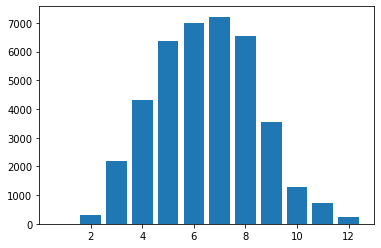

In [63]:
x = zone_distribution['Zone_List']
y = zone_distribution['count']

plt.bar(x, y)

plt.show()


## The most common are from zones that are right in the middle. 
## According to the USDA's Plant Hardiness website, MOBOT's zipcode says it is in zone 6. 

# But I have some questions now!

## So let's get to them.

1. In zone 6, what kind of read flowering plants can I plant?
2. Additionally, what are going to be hardy to plant?

In [64]:
q2_df = df.query('Bloom_Description.str.contains("Red").values')

In [65]:
q2_df['id'].count()

450

### MOBOT has a data on exactly what kind of Flowering a plant has. In this case, we just want anything that is NOT "nonflowering". That is why we're using the "~" in front. So give us all the flowers!

In [66]:
q2_df = q2_df.query('~Flower.str.contains("nonFlowering").values')

In [67]:
q2_df['id'].count()

450

### Finally, we know that is matters where we are going to plant them. Let's say we're local to the MOBOT and live in St. Louis, MO. So according to the USDA we are in the plant hardiness zone, 6. So let's just look at the black flowers that can grow well there.

In [68]:
q2_df['Zone_List'] = q2_df['Zone_List'].astype(str)

In [69]:
q2_df = q2_df.query('Zone_List.str.contains("6").values')

In [70]:
q2_df['id'].count()

359

### Some more things that I want...low maintaince. I want "showy" flowers that I can cut and use for a bouquet. And I don't want to them to need a lot of water

In [71]:
q2_df = q2_df.query('Maintenance.str.contains("Low").values')
q2_df = q2_df.query('Flower.str.contains("Showy").values')
q2_df = q2_df.query('Flower.str.contains("Fragrant").values')
q2_df = q2_df.query('Flower.str.contains("Cut").values')
q2_df = q2_df.query('~Water.str.contains("Wet").values')
q2_df = q2_df.query('~Water.str.contains("wet").values')
q2_df = q2_df.query('~Water.str.contains("Water").values')

In [72]:
q2_df['id'].count()

11

### It isn't terribly surprising we haven't narrowed down our search too much. We already know from looking at the broader trends in the data at moderate zones like 6 are abundant in the MOBOT Plant Finder dataset. 20 still gives us a selection. So let's take a look at it!

#### What can I plant for a showy, fragrant, low-maintenance flower garden that is all red in the St. Louis, MO region?

In [75]:
display_data = q2_df[['Common Name', 
                      'Formal Name', 
                      'Flower', 
                      'Native Range', 
                      'Sun', 
                      'Water', 
                      'Suggested Use', 
                      'Maintenance']]
display_data = display_data.reset_index(drop=True)
display_data

,Common Name,Formal Name,Flower,Native Range,Sun,Water,Suggested Use,Maintenance
0,Chinese lilac,Syringa chinensis Red Rothomagensis,Showy Fragrant Good Cut,Eastern Mediterranean,Full sun,Medium,Hedge,Low
1,common lilac,Syringa vulgaris Charles Joly,Showy Fragrant Good Cut,Northern China Manchuria Korea,Full sun,Medium,Hedge,Low
2,peony,Paeonia Zhu Sha Pan CINNABAR RED,Showy Fragrant Good Cut,Europe to western Asia,Full sun to part shade,Medium,Hedge Naturalize,Low
3,butterfly bush,Buddleja davidii Monum PETITE PLUM,Showy Fragrant Good Cut,Western Himalayas,Full sun,Medium,Naturalize,Low
4,butterfly bush,Buddleja davidii PIIBDII FIRST EDITIONS FUNKY ...,Showy Fragrant Good Cut,Southern Europe to Great Britain,Full sun,Medium,Naturalize,Low
5,blanket flower,Gaillardia Tizzy,Showy Fragrant Good Cut,China Japan,Full sun,Dry to medium,Naturalize,Low
6,coneflower,Echinacea Emily Saul BIG SKY AFTER MIDNIGHT,Showy Fragrant Good Cut Good Dried,Southcentral China Myanmar Taiwan Vietnam,Full sun to part shade,Dry to medium,Hedge Rain Garden,Low
7,miscellaneous tulip,Tulipa Little Beauty,Showy Fragrant Good Cut,Mediterranean Asia,Full sun,Medium,Annual Naturalize,Low
8,coneflower,Echinacea Meteor Red,Showy Fragrant Good Cut,Southeastern United States,Full sun to part shade,Dry to medium,Naturalize,Low
9,blanket flower,Gaillardia Frenzy,Showy Fragrant Good Cut,Canada to Mexico,Full sun,Dry to medium,Hedge,Low
